In [16]:
# STEP 1: Data Acquisition

import os
import pandas as pd
import numpy as np

# Check working directory and CSV availability
print("Notebook working directory:", os.getcwd())
print("CSV exists (relative):", os.path.exists('netflix_titles.csv'))
print("CSV absolute path exists:", os.path.exists('/Users/imran/Desktop/Nouveau dossier (2)/netflixandtvshows/netflix_titles.csv'))

# Load the dataset (use relative path if available, otherwise fall back to absolute)
try:
    csv_path = 'netflix_titles.csv'
    if not os.path.exists(csv_path):
        csv_path = '/Users/imran/Desktop/Nouveau dossier (2)/netflixandtvshows/netflix_titles.csv'
    df = pd.read_csv(csv_path)
    print("Dataset loaded successfully.")
    print(f"Dimensions: {df.shape}")
except FileNotFoundError:
    print("Error: 'netflix_titles.csv' not found at either path.")
    df = pd.DataFrame()


Notebook working directory: c:\Users\imran\Desktop\Nouveau dossier (2)\netflixandtvshows
CSV exists (relative): True
CSV absolute path exists: True
Dataset loaded successfully.
Dimensions: (8807, 12)


In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("seaborn-v0_8")
sns.set_palette("Set2")

df = pd.read_csv("/Users/imran/Desktop/Nouveau dossier (2)/netflixandtvshows/netflix_titles.csv")


Analyse univariée

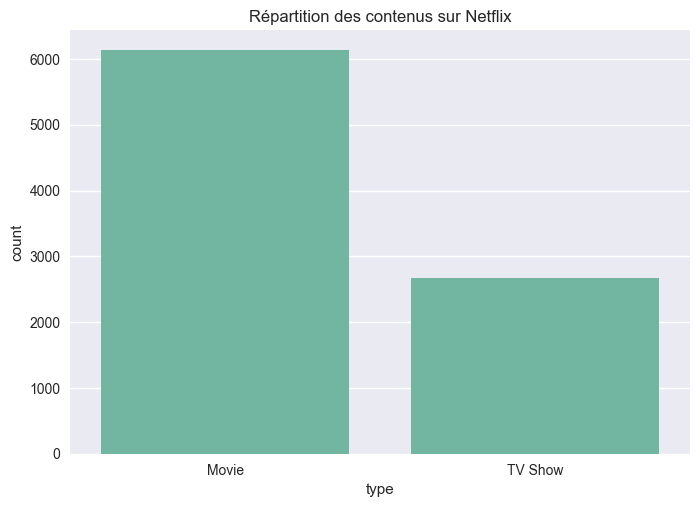

In [22]:
sns.countplot(data=df, x="type")
plt.title("Répartition des contenus sur Netflix")
plt.show()

Interprétation : 

La répartition des contenus sur Netflix est à hauteur d'environ 70% de films pour environ 30% de TV Show

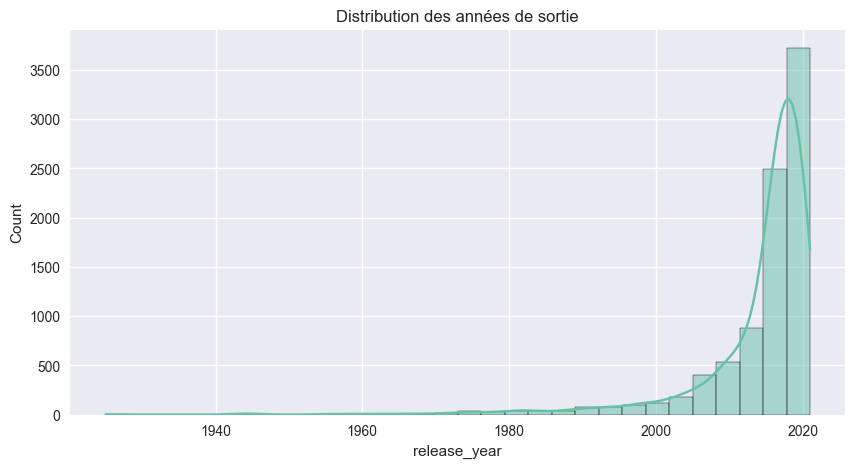

In [23]:
plt.figure(figsize=(10,5))
sns.histplot(df["release_year"], bins=30, kde=True)
plt.title("Distribution des années de sortie")
plt.show()

Interprétation :

On a une forte concentration de films publiés après les années 2000 donc une asymétrie par la gauche et pas vraiment de valeurs aberrantes/outliers comme on peut le constater

Durée des contenus

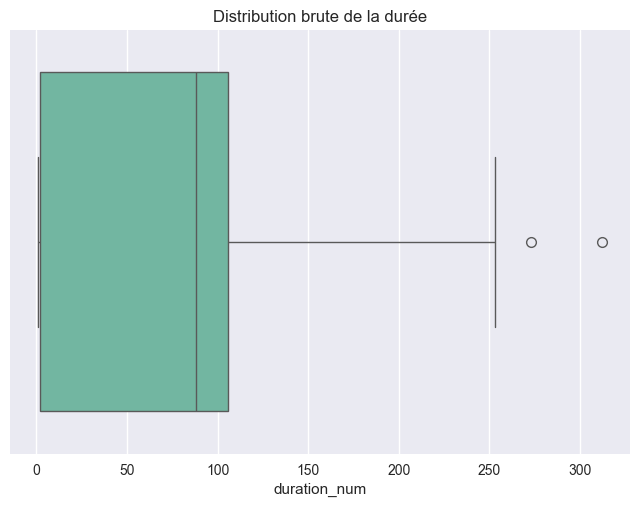

In [24]:
df["duration_num"] = df["duration"].str.extract(r"(\d+)").astype(float)
sns.boxplot(x=df["duration_num"])
plt.title("Distribution brute de la durée")
plt.show()

Interprétation : 

On remarque une forte asymétrie à droite sur le boxplot. Le gros des valeurs (autour de 90-100) concerne les films. Quant aux outliers, ce ne sont pas des anomalies mais le résultat du mélange entre les durées de films et le nombre de saisons des séries.

Analyse bivariée

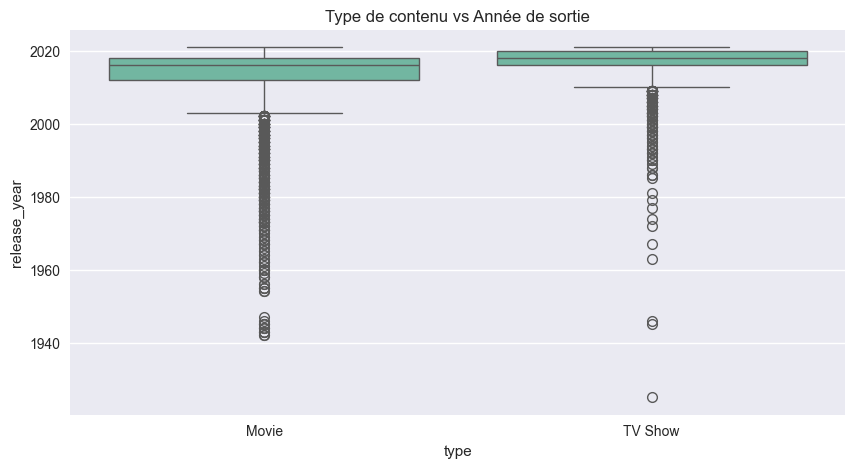

In [25]:
plt.figure(figsize=(10,5))
sns.boxplot(data=df, x="type", y="release_year")
plt.title("Type de contenu vs Année de sortie")
plt.show()

Interprétation :

Le boxplot montre bien que les séries sur Netflix sont généralement plus récentes que les films, avec une médiane et des quartiles plus hauts. Pour les films, on a une dispersion beaucoup plus grande et pas mal d'outliers qui remontent jusqu'aux années 40-60 : ça prouve que Netflix garde un gros catalogue de classiques. Par contre, les séries sont presque toutes concentrées après 2010

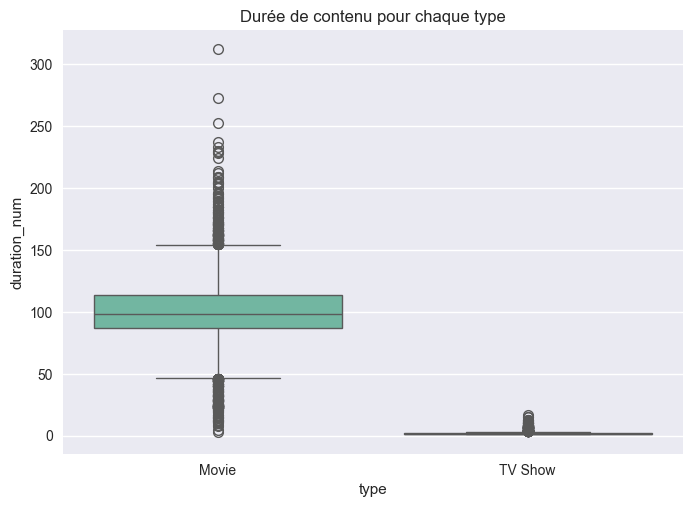

In [35]:
sns.boxplot(data=df, x="type", y="duration_num")
plt.title("Durée de contenu pour chaque type")
plt.show()

Interprétation :

Ce graphique confirme que la durée est le meilleur indicateur pour différencier les deux types de contenus. Les films sont surtout regroupés entre 90 et 100 minutes, même s'il y a pas mal de variabilité et d'outliers (des films très courts ou super longs). Pour les séries, les valeurs sont très basses puisque c'est le nombre de saisons qui est compté. Du coup, ça crée une séparation presque nette entre les deux catégories.

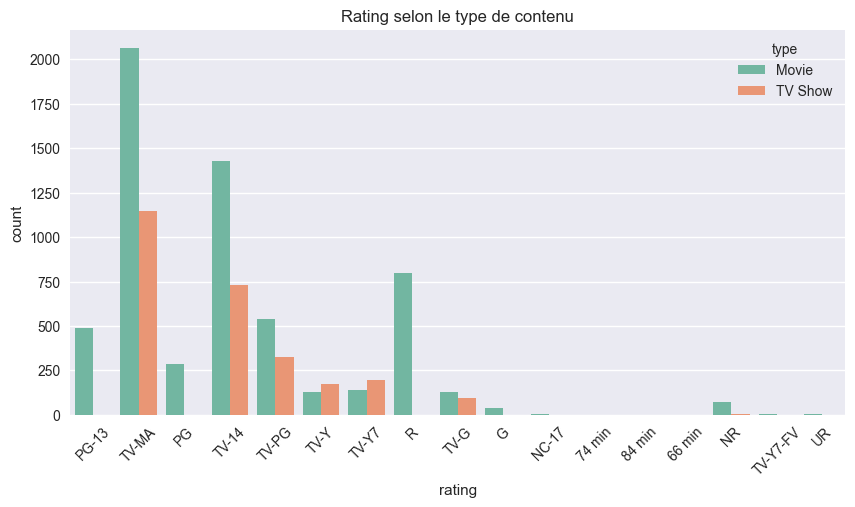

In [ ]:
plt.figure(figsize=(10,5))
sns.countplot(data=df, x="rating", hue="type")
plt.xticks(rotation=45)
plt.title("Rating selon le type de contenu")
plt.show()

Interprétation :

Le graphique montre une corrélation super nette entre le rating et le type de programme. Pour les séries, on retrouve surtout des classifications spécifiques à la télé (comme TV-MA ou TV-14). Les films, eux, touchent à tout et utilisent plutôt les codes du cinéma (PG, R, etc.).

Pour le modèle, c'est clairement une variable clé pour classer les contenus. Par contre, il va falloir faire un peu de nettoyage et de normalisation, parce qu'il y a des erreurs dans les données (comme le "74 min" qui s'est glissé dans les ratings). Si on ne traite pas ce bruit, ça risque de fausser les prédictions.

Analyse multivariée

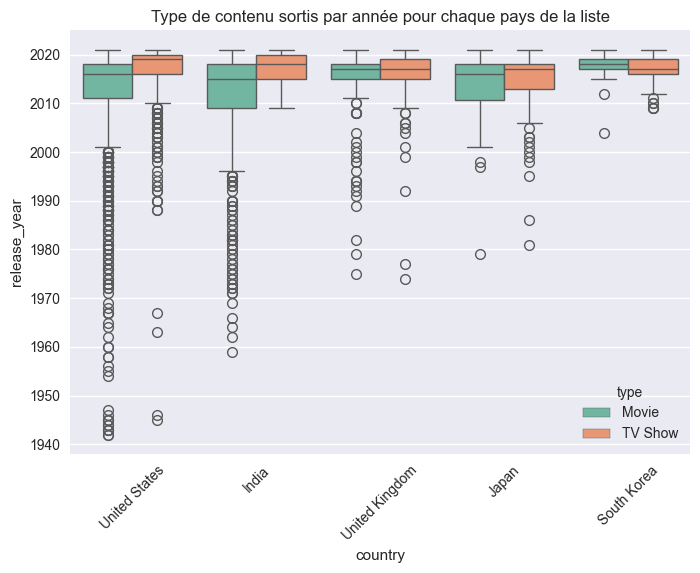

In [34]:
top_countries = df["country"].value_counts().head(5).index
df_top = df[df["country"].isin(top_countries)]

sns.boxplot(data=df_top, x="country", y="release_year", hue="type")
plt.xticks(rotation=45)
plt.title("Type de contenu sortis par année pour chaque pays de la liste")
plt.show()


Interprétation :

Ce graphique montre que la géographie joue pas mal sur l'ancienneté des contenus. Ce qui saute aux yeux, c'est que peu importe le pays, les séries sont toujours plus récentes que les films. Ça confirme bien que Netflix mise à fond sur le format sériel depuis quelques années.

On remarque aussi que les États-Unis et l’Inde ont un catalogue de films très étalé dans le temps (beaucoup de vieux classiques), alors que pour la Corée du Sud ou le Japon, tout est beaucoup plus récent, surtout les séries.

Corrélation et Association

In [ ]:
df[["release_year", "duration_num"]].corr()

,release_year,duration_num
release_year,1.000000,-0.249182
duration_num,-0.249182,1.000000


In [30]:
from scipy.stats import chi2_contingency

def cramers_v(x, y):
    confusion = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion)[0]
    n = confusion.sum().sum()
    return np.sqrt(chi2 / (n * (min(confusion.shape)-1)))

cramers_v(df["rating"], df["type"])


np.float64(0.34498634645552567)

Interprétation :

La matrice de corrélation montre qu'il n'y a pas de redondance entre nos variables numériques. Par contre, le test du V de Cramér confirme qu'il y a un vrai lien entre le rating et le type de contenu. Ça prouve que ces variables sont pertinentes et qu'on a raison de les garder pour notre modèle.

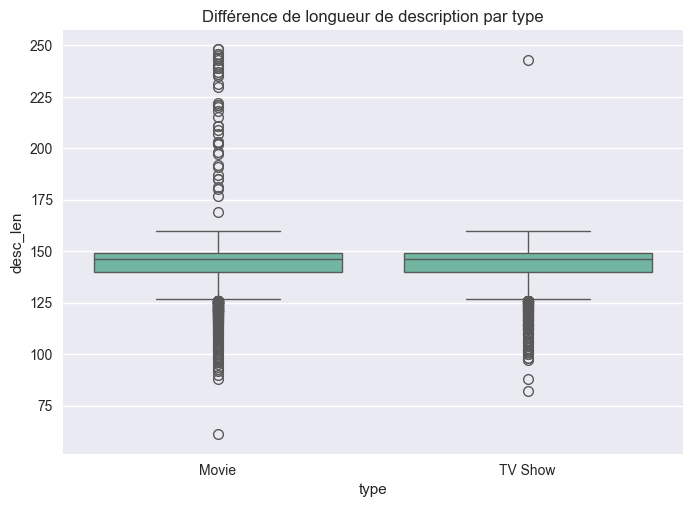

In [36]:
df["desc_len"] = df["description"].str.len()
sns.boxplot(data=df, x="type", y="desc_len")
plt.title("Différence de longueur de description par type")
plt.show()


Interprétation : 

Sur ce graphique, on voit que la longueur des descriptions est quasiment la même pour les films et les séries : les médianes se touchent et les blocs se superposent largement. Les films sont juste un peu plus variés avec quelques outliers (des descriptions soit très brèves, soit très longues).

La longueur de la description ne va pas beaucoup nous aider à deviner le type de contenu. Pour que ce soit utile au modèle, il faudra sûrement passer par des mots-clés pour analyser ce qui est écrit plutôt que de juste compter les caractères.